In [6]:
import numpy as np
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

In [20]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = torch.nn.Sequential(
            # The size of the picture is 28x28
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            # The size of the picture is 14x14
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            # The size of the picture is 7x7
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),

            torch.nn.Flatten(),
#             torch.nn.Linear(in_features=7 * 7 * 16, out_features=32),
#             torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(in_features=7 * 7 * 64, out_features=10),
        )

    def forward(self, input):
        output = self.model(input)
        return output

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=[0.5], std=[0.5])])

BATCH_SIZE = 1000
EPOCHS = 3
trainData = torchvision.datasets.MNIST('./data/', train=True, transform=transform, download=True)
testData = torchvision.datasets.MNIST('./data/', train=False, transform=transform)

trainDataLoader = torch.utils.data.DataLoader(dataset=trainData, batch_size=BATCH_SIZE, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(dataset=testData, batch_size=BATCH_SIZE)
net = Net()
print(net.to(device))

lossF = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

Net(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=3136, out_features=10, bias=True)
  )
)


In [22]:
testLoss = 0
testAccuracy = 0
test_log_loss = []
test_log_Acc = []
history = {'Test Loss': [], 'Test Accuracy': []}
for epoch in range(1, EPOCHS + 1):
    processBar = tqdm(trainDataLoader, unit='step')
    net.train(True)
    for step, (trainImgs, labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)

        net.zero_grad()
        outputs = net(trainImgs)
        loss = lossF(outputs, labels)
        predictions = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predictions == labels) / labels.shape[0]
        #loss.backward(retain_graph = True)
        loss.backward()

        optimizer.step()
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" %
                                   (epoch, EPOCHS, loss.item(), accuracy.item()))

        if step == len(processBar) - 1:
            correct, totalLoss = 0, 0
            net.train(False)
            with torch.no_grad():
                for testImgs, labels in testDataLoader:
                    testImgs = testImgs.to(device)
                    labels = labels.to(device)
                    outputs = net(testImgs)
                    loss = lossF(outputs, labels)
                    predictions = torch.argmax(outputs, dim=1)

                    totalLoss += loss
                    correct += torch.sum(predictions == labels)

                    testAccuracy = correct / (BATCH_SIZE * len(testDataLoader))
                    testLoss = totalLoss / len(testDataLoader)
                    history['Test Loss'].append(testLoss.cpu().numpy())
                    history['Test Accuracy'].append(testAccuracy.cpu().numpy())
            test_log_loss.append(testLoss.cpu().numpy())
            test_log_Acc.append(testAccuracy.cpu().numpy())
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" %(epoch, EPOCHS, loss.item(), accuracy.item(), testLoss, testAccuracy))
    processBar.close()

[1/3] Loss: 0.2283, Acc: 0.9260, Test Loss: 0.2107, Test Acc: 0.9410: 100%|██████████| 60/60 [00:28<00:00,  2.14step/s]
[2/3] Loss: 0.1047, Acc: 0.9650, Test Loss: 0.1044, Test Acc: 0.9658: 100%|██████████| 60/60 [00:34<00:00,  1.75step/s]
[3/3] Loss: 0.0717, Acc: 0.9680, Test Loss: 0.0662, Test Acc: 0.9794: 100%|██████████| 60/60 [00:32<00:00,  1.82step/s]


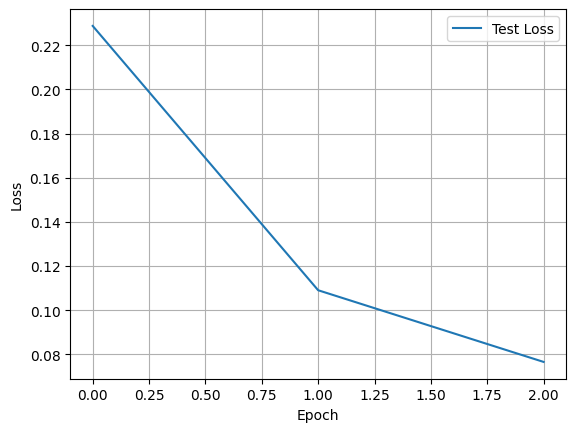

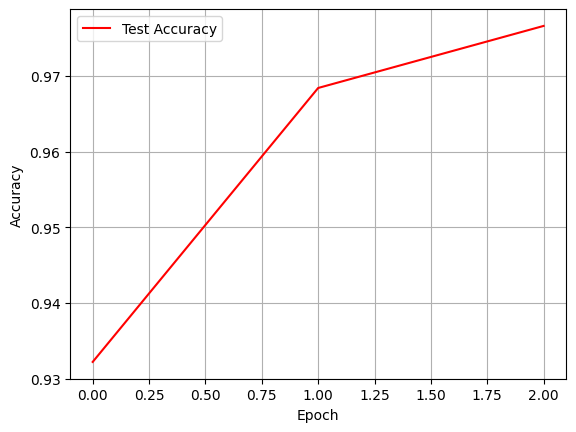

In [10]:
times = np.arange(EPOCHS)

plt.plot(times,test_log_loss, label='Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(times,test_log_Acc, color='red', label='Test Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
